# Sea ice analysis

In [92]:
%matplotlib inline
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.latlon_analysis import time_mean_latlon
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
import numpy as np
import xarray as xr
from mom6_tools.m6plot import polarplot
import warnings
warnings.filterwarnings("ignore")

In [93]:
# The following parameters must be set accordingly
######################################################
# case name - must be changed for each configuration
case_name = 'g.c2b6.GJRA.TL319_t061.long_JRA_mct.001'
# Path to the run directory
path = "/glade/scratch/gmarques/"+case_name+"/run/"
# name of ocean static file
static = case_name+'.mom6.static.nc'
# name of seaice file
seaice = case_name+'.cice.h.*.nc'
# initial and final years for computing time mean
year_start = 1
year_end = 60
# array with 2D forcing variables to be processed
variables = ['SST','SSS','SSH']
# Put your name and email address below
author = 'Gustavo Marques (gmarques@ucar.edu)'
######################################################
# create an empty class object
class args:
  pass

args.infile = path+seaice
args.year_start = year_start
args.year_end = year_end
args.case_name = case_name
args.variables = variables
args.savefigs = False
args.time_series = True

In [94]:
# load mom6 grid
grd = MOM6grid(path+static)
# load sea ice data
seaice = xr.open_mfdataset(args.infile, decode_times=False)
seaice['time'] = seaice.time/365. # time in years

MOM6 grid successfully loaded... 



## Mean sea ice thickness 

In [95]:
# compute time mean global
hi_mean = np.ma.masked_invalid(seaice['hi'].sel(time=slice(args.year_start,args.year_end)).mean('time').data)
# mask northern hemisphere
hi_mean_sh = np.ma.masked_where(grd.geolat > 0., hi_mean)
# mask southern hemisphere
hi_mean_nh = np.ma.masked_where(grd.geolat < 0., hi_mean)

### Southern Hemisphere

myStats: min = 0.0
myStats: max = 3.07656
myStats: sum(area) = 505637880000000.0
myStats: sum(area) = 205900480000000.0 after masking
myStats: sum(s) = 9613.92
myStats: sum(area*s) = 6371169300000.0
myStats: mean(s) = 0.030942954
myStats: std(s) = 0.12657066836900743
myStats: rms(s) = 0.13029812260085463


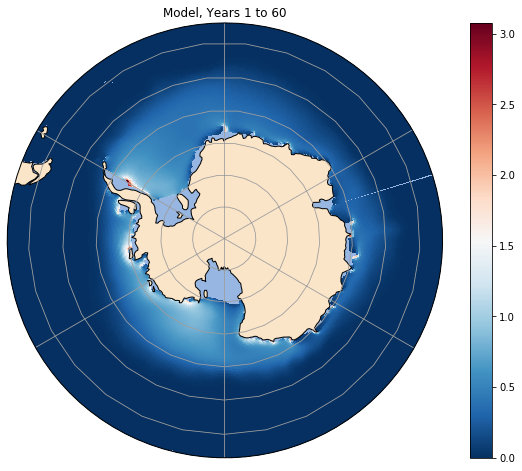

In [96]:
title = ('Model, Years ' + str(args.year_start) + ' to ' + str(args.year_end))
polarplot(hi_mean_sh, grd, title=title, debug=True, colormap='RdBu_r')

### Northern Hemisphere

myStats: min = 0.0
myStats: max = 5.2895694
myStats: sum(area) = 505637880000000.0
myStats: sum(area) = 153880490000000.0 after masking
myStats: sum(s) = 17721.021
myStats: sum(area*s) = 18884703000000.0
myStats: mean(s) = 0.12272318
myStats: std(s) = 0.4638930624722075
myStats: rms(s) = 0.4798517995772186


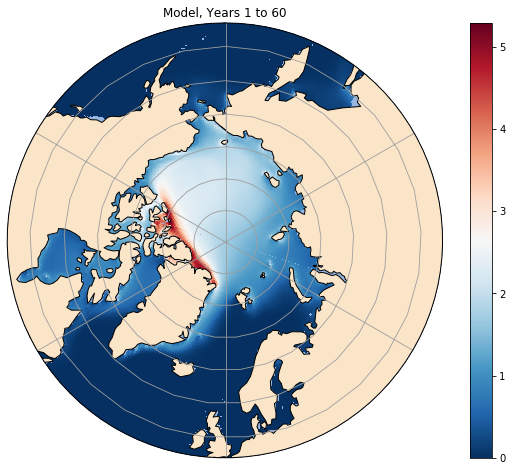

In [97]:
polarplot(hi_mean_nh, grd, proj='NP', title=title, debug=True, colormap='RdBu_r')

## Time series 

### Maximum sea ice thickness 

In [98]:
from mom6_tools.latlon_analysis import create_xarray_dataset, plot_area_ave_stats
from mom6_tools.m6plot import myStats

In [99]:
dtime = seaice.time.values
# variable name
var = 'hi'
# create datasets
ds_sh = create_xarray_dataset(var,'m',dtime)
ds_nh = create_xarray_dataset(var,'m',dtime)

# loop in time
for t in range(0,len(dtime)):
    # northern hemisphere
    tmp = np.ma.masked_invalid(seaice[var].sel(time=dtime[t]).values)
    tmp_nh = np.ma.masked_where(grd.geolat < 0, tmp)
    # get stats
    sMin, sMax, mean, std, rms = myStats(tmp_nh, area=None)
    # update Dataset
    ds_nh[var][1,t]  = sMax
    # southern hemisphere
    tmp_sh = np.ma.masked_where(grd.geolat > 0, tmp)
    # get stats
    sMin, sMax, mean, std, rms = myStats(tmp_sh, area=None)
    # update Dataset
    ds_sh[var][1,t] = sMax

#### Southern Hemisphere

Text(0.5, 0, 'Time [years]')

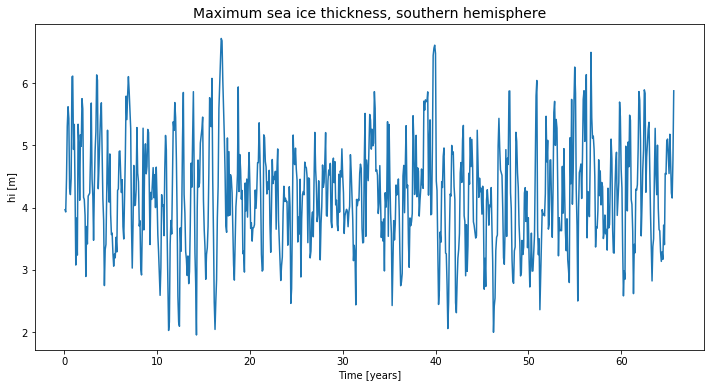

In [100]:
sh = ds_sh.sel(stats='max')
fig = plt.figure(figsize=(12, 6))
ax  = fig.add_subplot(111)
sh.hi.plot(ax=ax)
plt.title('Maximum sea ice thickness, southern hemisphere', fontsize=14)
plt.xlabel('Time [years]')

#### Northern Hemisphere

Text(0.5, 0, 'Time [years]')

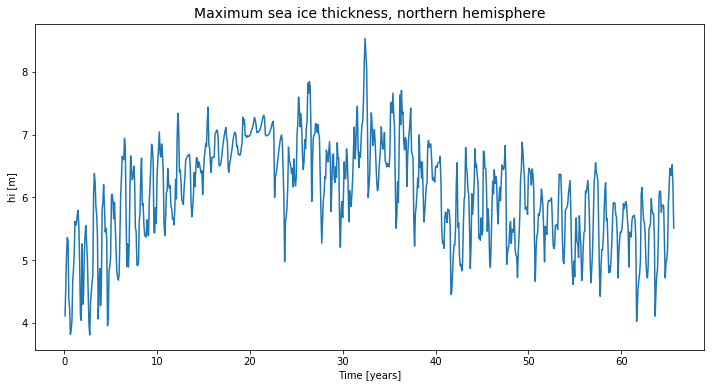

In [101]:
nh = ds_nh.sel(stats='max')
fig = plt.figure(figsize=(12, 6))
ax  = fig.add_subplot(111)
nh.hi.plot(ax=ax)
plt.title('Maximum sea ice thickness, northern hemisphere', fontsize=14)
plt.xlabel('Time [years]')

### Sea ice extent

In [131]:
dtime = seaice.time.values
# variable name
var = 'aice'
# 
area_sh = []
area_nh = []

# loop in time
for t in range(len(dtime)):
    tmp = np.ma.masked_invalid(seaice[var].sel(time=dtime[t]).values)
    # mask southern hemisphere
    tmp_nh = np.ma.masked_where(grd.geolat < 0, grd.area_t)
    # mask northern hemisphere
    tmp_sh = np.ma.masked_where(grd.geolat > 0, grd.area_t)
    # mask if aggregrated concentration <= 0.15
    tmp_nh = np.ma.masked_where(tmp <= 0.15, tmp_nh*tmp)
    tmp_sh = np.ma.masked_where(tmp <= 0.15, tmp_sh*tmp)
    # append data
    area_sh.append(np.sum(tmp_sh)*1.0e-12) # 1.0e6 km^2
    area_nh.append(np.sum(tmp_nh)*1.0e-12) # 1.0e6 km^2

#### Southern hemisphere

Text(0, 0.5, 'x 1.0e6 km$^2$')

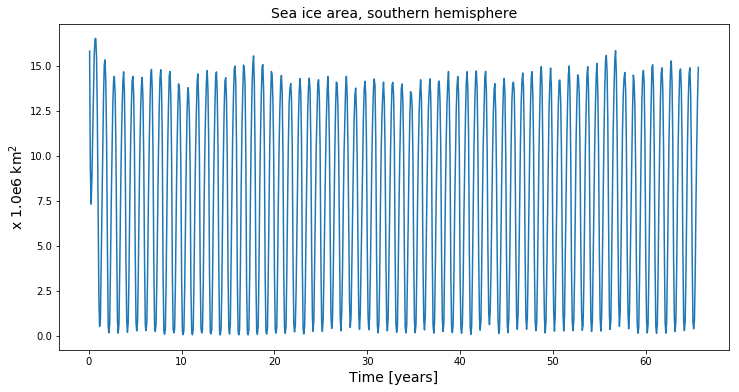

In [143]:
fig = plt.figure(figsize=(12, 6))
plt.plot(dtime,area_sh)
plt.title('Sea ice area, southern hemisphere', fontsize=14)
plt.xlabel('Time [years]', fontsize=14); plt.ylabel('x 1.0e6 km$^2$', fontsize=14)

#### Northern hemisphere

Text(0, 0.5, 'x 1.0e6 km$^2$')

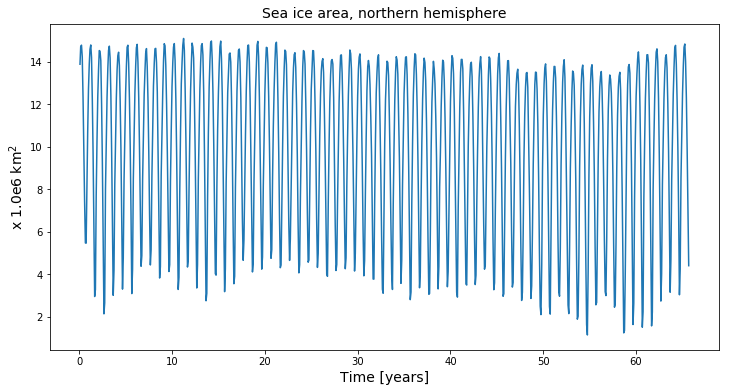

In [142]:
fig = plt.figure(figsize=(12, 6))
plt.plot(dtime,area_nh)
plt.title('Sea ice area, northern hemisphere', fontsize=14)
plt.xlabel('Time [years]', fontsize=14); plt.ylabel('x 1.0e6 km$^2$', fontsize=14)

### Under development

Text(0.5, 1.0, 'Model, Years 1 to 60')

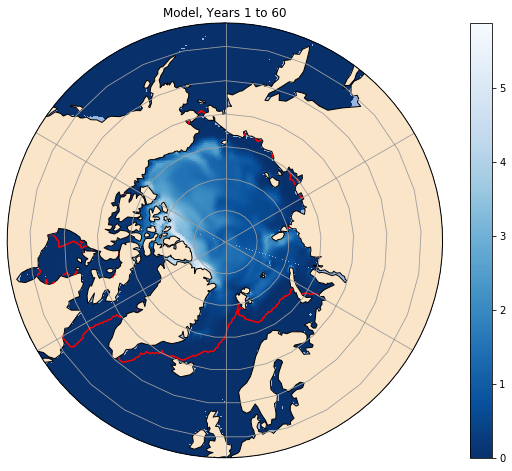

In [102]:
import matplotlib.path as mpath
fig = plt.figure(figsize=[10, 8])
ice = (seaice.aice[-1,:,:].data)
ax1 = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
ax1.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
ax1.add_feature(cartopy.feature.LAND)
ax1.gridlines()
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)
#colormap = 'rainbow'
cs = ax1.pcolormesh(grd.geolon,grd.geolat,ice,transform=ccrs.PlateCarree(),cmap='Blues_r', shading='flat')
fig.colorbar(cs)
# Add Land
ax1.add_feature( cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='#fae5c9') #fae5c9')
# add Ocean
ax1.add_feature(cartopy.feature.OCEAN)
# Add coastline
ax1.coastlines(color='black')
# Add lat lon rings
ax1.gridlines(alpha='0.1',color='black')
im1 = ax1.contour(grd.geolon,grd.geolat,ice,[15],colors='red', transform=ccrs.PlateCarree())
plt.title('Model, Years ' + str(args.year_start) + ' to ' + str(args.year_end))